### 5 different applications in this notebook:


*   Application 1: get different GAM models from the Rashomon set.
*   Application 2: get variable importance range.


*   Application 3: find the model that satisfies the monotonic constraints.
*  Application 4: find the users' preferred shape functions.


*   Application 5: explore sudden changes or abnormal patterns in the shape function.


In [1]:
!git clone https://github.com/chudizhong/GAMsRashomonSet.git

Cloning into 'GAMsRashomonSet'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 43 (delta 17), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (43/43), 435.47 KiB | 7.26 MiB/s, done.
Resolving deltas: 100% (17/17), done.


In [2]:
!ls GAMsRashomonSet/src

prepare_gam.py	rset_app.py  rset_opt.py  run_app.py  utils.py


In [3]:
!ls GAMsRashomonSet/src/rset_opt.py

GAMsRashomonSet/src/rset_opt.py


In [4]:
import sys
sys.path.append('/content/GAMsRashomonSet')

In [5]:
from src import rset_opt
print(dir(rset_opt))

['RSetOPT', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'combinations', 'nn', 'np', 'pd', 'pickle', 'time', 'torch', 'utils', 'warnings']


## Import Libraries

In [6]:
import numpy as np
import pandas as pd
import pickle
import os, sys, time, warnings
from matplotlib import pyplot as plt

REPO_ROOT = "."
if REPO_ROOT not in sys.path:
    sys.path.insert(0, REPO_ROOT)

import src.utils as utils
from src.rset_opt import RSetOPT
from src.rset_app import RSetGAMs
from src.run_app import (
    get_models_from_rset,
    variable_importance_range,
    get_monotone,
    get_projection,
)
print("All imports OK.")

All imports OK.


## Load data, select top 7 features, bin into 5 bins

In [7]:
RAW_CSV = "/content/Breast Cancer Wisconsin.csv"
df = pd.read_csv(RAW_CSV)
df = df.drop(columns=['id', 'Unnamed: 32'])

# Encode target
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

# Top 7 features selected by Random Forest importance + correlation with target
TOP7 = ['concave points_worst', 'perimeter_worst', 'area_worst',
        'concave points_mean',  'radius_worst',    'perimeter_mean', 'radius_mean']

# ── CRITICAL: use 5 bins instead of 10 ──────────────────────────────────────
# mcr_plus_lp runs 2^(n_bins) LP solves per feature.
#   10 bins → 1024 solves/feature × 7 features = 7,168 solves  (very slow)
#    5 bins →   32 solves/feature × 7 features =   224 solves  (~32x faster)
N_BINS = 5

df_binned = df[TOP7].copy()
for col in TOP7:
    df_binned[col] = pd.cut(df[col], bins=N_BINS, labels=False, duplicates='drop')

df_binned['diagnosis'] = df['diagnosis'].values

os.makedirs("datasets", exist_ok=True)
DNAME = "breast_cancer_wisconsin"
df_binned.to_csv(f"datasets/{DNAME}.csv", index=False)

print(f"Saved datasets/{DNAME}.csv  — shape: {df_binned.shape}")
for col in TOP7:
    print(f"  {col}: {df_binned[col].nunique()} bins")

Saved datasets/breast_cancer_wisconsin.csv  — shape: (569, 8)
  concave points_worst: 5 bins
  perimeter_worst: 5 bins
  area_worst: 5 bins
  concave points_mean: 5 bins
  radius_worst: 5 bins
  perimeter_mean: 5 bins
  radius_mean: 5 bins


## Binary encode, and  fit initial Logistic Regression

In [8]:
from sklearn.linear_model import LogisticRegression

LAMB0      = 0.001
LAMB2      = 0.001
MULTIPLIER = 1.01

data = pd.read_csv(f"datasets/{DNAME}.csv")

X_orig, counts = utils.one_hot_encoding(data.iloc[:, :-1], one_hot=False)
y_orig = pd.DataFrame(data.iloc[:, -1])

header = pd.Index(["intercept"] + list(X_orig.columns)).astype("object")
print(f"Binary feature matrix shape: {X_orig.shape}")  # expect ~(569, 35)

X_arr, y_arr = utils.get_X_y(X_orig, y_orig)
lamb    = 2 * LAMB2
y_01    = (y_arr + 1) // 2

sample_p = np.concatenate(([1.0], X_orig.values.mean(axis=0)))
sample_p = np.clip(sample_p, 1e-5, 1)
X_norm   = X_arr / np.sqrt(sample_p)

lr = LogisticRegression(C=1/lamb, fit_intercept=False,
                        solver='liblinear', max_iter=2000)
lr.fit(X_norm, y_01.ravel())

w_orig = lr.coef_.ravel() / np.sqrt(sample_p)
acc, auc = utils.get_acc_and_auc(w_orig, X_arr, y_arr)
print(f"w_orig shape: {w_orig.shape}")
print(f"Accuracy: {acc:.4f},  AUC: {auc:.4f}")

Binary feature matrix shape: (569, 35)
w_orig shape: (36,)
Accuracy: 0.9473,  AUC: 0.9842


## One-hot shape functions + refined weights

In [9]:
X_new, header_new = utils.binary_to_one_hot(data.iloc[:, :-1], w_orig, header)

sample_p_new = X_new.sum(axis=0) / X_new.shape[0]
sample_p_new = np.clip(sample_p_new, 1e-5, 1)
X_new_norm   = X_new / np.sqrt(sample_p_new)

lr2 = LogisticRegression(C=1/lamb, fit_intercept=True,
                         solver='liblinear', max_iter=2000)
lr2.fit(X_new_norm[:, 1:], y_01.ravel())

w_new_norm = np.concatenate([lr2.intercept_.ravel(), lr2.coef_.ravel()])
w_new      = w_new_norm / np.sqrt(sample_p_new)

print(f"X_new shape:  {X_new.shape}")
print(f"w_new shape:  {w_new.shape}")
print(f"Any NaN:      {np.any(np.isnan(w_new))}")

pair before removing {np.str_('concave points_worst'): [0.0, 1.0, 2.0, 3.0, 4.0], np.str_('perimeter_worst'): [0.0, 1.0, 2.0, 3.0, 4.0], np.str_('area_worst'): [0.0, 1.0, 2.0, 3.0, 4.0], np.str_('concave points_mean'): [0.0, 1.0, 2.0, 3.0, 4.0], np.str_('radius_worst'): [0.0, 1.0, 2.0, 3.0, 4.0], np.str_('perimeter_mean'): [0.0, 1.0, 2.0, 3.0, 4.0], np.str_('radius_mean'): [0.0, 1.0, 2.0, 3.0, 4.0]}
k, v concave points_worst [0.0, 1.0, 2.0, 3.0, 4.0]
k, v perimeter_worst [0.0, 1.0, 2.0, 3.0, 4.0]
k, v area_worst [0.0, 1.0, 2.0, 3.0, 4.0]
k, v concave points_mean [0.0, 1.0, 2.0, 3.0, 4.0]
k, v radius_worst [0.0, 1.0, 2.0, 3.0, 4.0]
k, v perimeter_mean [0.0, 1.0, 2.0, 3.0, 4.0]
k, v radius_mean [0.0, 1.0, 2.0, 3.0, 4.0]
pair after removing {np.str_('concave points_worst'): [0.0, 1.0, 2.0, 3.0, 4.0], np.str_('perimeter_worst'): [0.0, 1.0, 2.0, 3.0, 4.0], np.str_('area_worst'): [0.0, 1.0, 2.0, 3.0, 4.0], np.str_('concave points_mean'): [0.0, 1.0, 2.0, 3.0, 4.0], np.str_('radius_worst'): [0

## Compute loss, Hessian, save pickle

In [10]:
log_loss = utils.get_log_loss(X_new, y_arr, w_new, LAMB2, sample_p_new)
H        = utils.hessian(w_new, X_new, y_arr, LAMB2, sample_p_new)
eps      = log_loss * MULTIPLIER

print(f"Log-loss:        {log_loss:.6f}")
print(f"Rashomon bound:  {eps:.6f}")

FILEPATH = f"{DNAME}_{LAMB0}_{LAMB2}_{MULTIPLIER}.p"

results = {
    "date"             : time.strftime("%d/%m/%y", time.localtime()),
    "data_file"        : DNAME,
    "X"                : X_new,
    "header_new"       : header_new,
    "p"                : w_new.shape[0],
    "sample_proportion": sample_p_new,
    "lamb0"            : LAMB0,
    "lamb2"            : LAMB2,
    "multiplier"       : MULTIPLIER,
    "rset_bound"       : eps,
    "w_orig"           : w_new,
    "log_loss_orig"    : log_loss,
    "hessian"          : H,
    "w_opt"            : w_new.copy(),
    "H_opt"            : H.copy(),
}

with open(FILEPATH, 'wb') as f:
    pickle.dump(results, f, protocol=pickle.DEFAULT_PROTOCOL)

print(f"Pickle saved: {FILEPATH}")

Log-loss:        3.739431
Rashomon bound:  3.776825
Pickle saved: breast_cancer_wisconsin_0.001_0.001_1.01.p


## Optimise Rashomon Set ellipsoid

In [11]:
model = RSetOPT(FILEPATH)
model.finetune_ellipsoid(n_iters=500)
model.get_precision()

model.update_file(model.get_normalized_H(), model.w_orig)
print("Ellipsoid optimisation complete.")

----------- before optimization -----------
volume proportional to  tensor(9.7946e+59, dtype=torch.float64, grad_fn=<MulBackward0>)
0 tensor(0.0216, dtype=torch.float64, grad_fn=<AddBackward0>)
1 tensor(0.0213, dtype=torch.float64, grad_fn=<AddBackward0>)
2 tensor(0.0210, dtype=torch.float64, grad_fn=<AddBackward0>)
3 tensor(0.0206, dtype=torch.float64, grad_fn=<AddBackward0>)
4 tensor(0.0203, dtype=torch.float64, grad_fn=<AddBackward0>)
5 tensor(0.0199, dtype=torch.float64, grad_fn=<AddBackward0>)
6 tensor(0.0195, dtype=torch.float64, grad_fn=<AddBackward0>)
7 tensor(23.6671, dtype=torch.float64, grad_fn=<AddBackward0>)
8 tensor(0.7639, dtype=torch.float64, grad_fn=<AddBackward0>)
9 tensor(0.0193, dtype=torch.float64, grad_fn=<AddBackward0>)
10 tensor(0.0194, dtype=torch.float64, grad_fn=<AddBackward0>)
11 tensor(0.0195, dtype=torch.float64, grad_fn=<AddBackward0>)
12 tensor(0.0195, dtype=torch.float64, grad_fn=<AddBackward0>)
13 tensor(0.0196, dtype=torch.float64, grad_fn=<AddBackwar

## Application-1: Sample models

<Figure size 550x400 with 0 Axes>

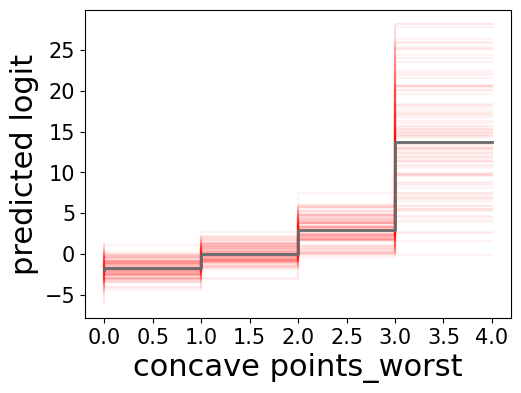

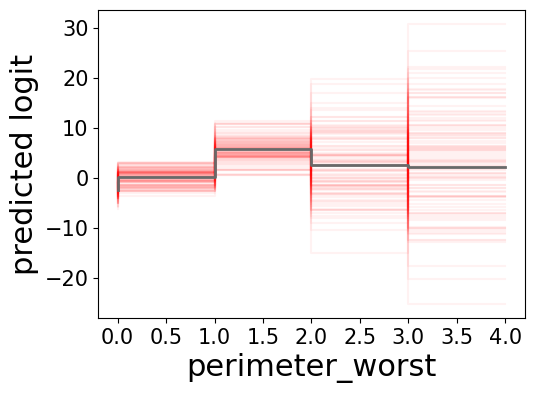

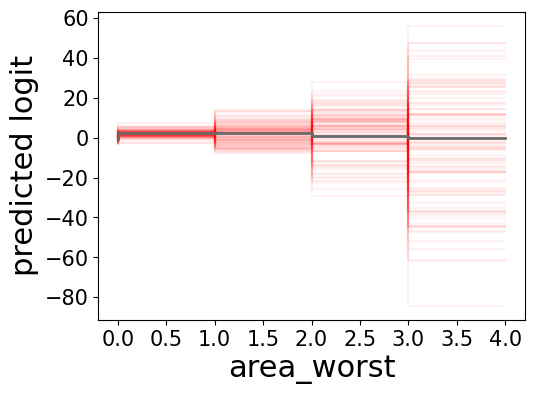

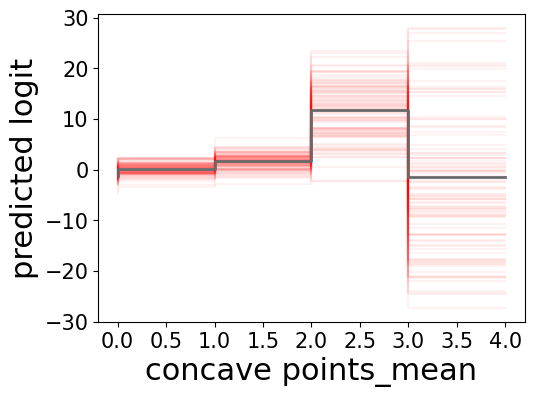

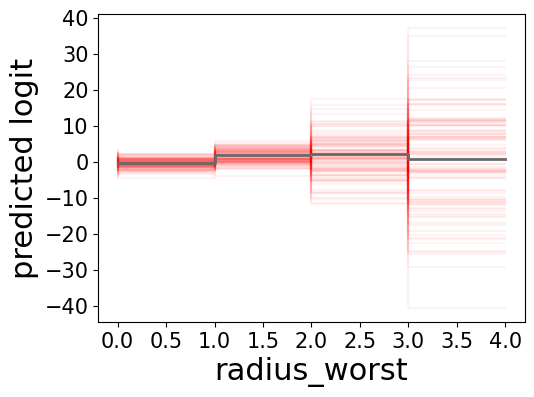

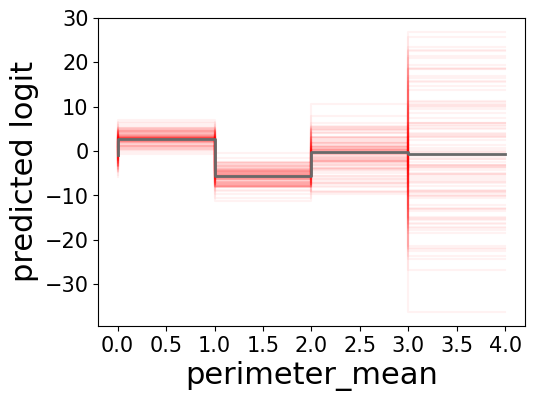

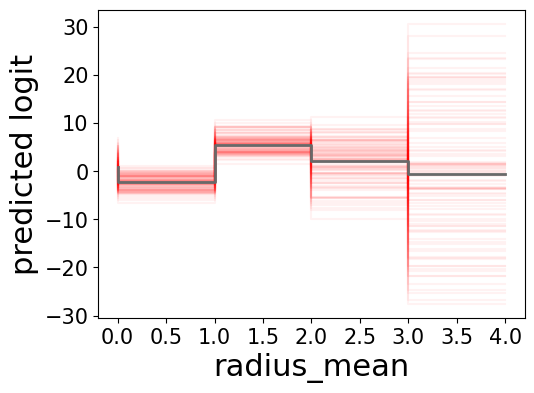

In [12]:
w_samples = get_models_from_rset(FILEPATH, n_samples=100, plot_shape=True)

## Application-2: Variable Importance Range

In [13]:
import cvxpy as cp

def mcr_plus_lp_fixed(self, f, fix=False):
    l, cnt = self.get_f_idx(f)
    pr = np.r_[np.zeros(l),
               np.array([sum(self.X[:, l+c]/self.N) for c in range(cnt)])]
    pr = np.r_[pr, np.zeros(self.P - l - cnt)].reshape(self.P, 1)

    binaries = self.get_binaries(cnt)
    res, res_obj = np.zeros((2**cnt, self.P)), np.zeros((2**cnt, 1))
    start = time.time()

    for j in range(2**cnt):
        w   = cp.Variable(self.P)
        row = -1 + 2 * binaries[j, :]
        tmp = np.zeros((self.P, 1))
        tmp[l:l+cnt, 0] = row
        cst = [w[l+c] * tmp[l+c] >= 0 for c in range(cnt)]

        if fix:
            prob = cp.Problem(
                cp.Maximize((pr * tmp).T @ w),
                [cp.quad_form(w - self.w_orig, self.H) <= 1] + cst +
                [w[c] == self.w_orig[c] for c in range(l)] +
                [w[c] == self.w_orig[c] for c in range(cnt+l, self.P)]
            )
        else:
            prob = cp.Problem(
                cp.Maximize((pr * tmp).T @ w),
                [cp.quad_form(w - self.w_orig, self.H) <= 1] + cst
            )

        solved = False
        for solver in [cp.SCS, cp.CLARABEL, cp.ECOS]:
            try:
                prob.solve(solver=solver, max_iters=10000)
                if w.value is not None:
                    solved = True
                    break
            except Exception:
                continue

        if solved and w.value is not None:
            res[j, :]     = w.value
            res_obj[j, 0] = prob.value
        else:
            warnings.warn(f"solution is None for pattern {j}")

    train_time = time.time() - start
    print("time:", train_time)
    best = np.argmax(res_obj)
    self.check_obj(res[best, :])
    return res[best, :], np.max(res_obj), train_time

RSetGAMs.mcr_plus_lp = mcr_plus_lp_fixed
print("Solver patched. Ready for Applications.")

Solver patched. Ready for Applications.


concave points_worst
----------------------variable importance Minus----------------------
Second solve time: 0.00595324
log obj: 0.2573864321505805 rset_bound: 3.77682499986352
Second solve time: 0.001649758
log obj: 0.20175484498820742 rset_bound: 3.77682499986352
----------------------variable importance plus LP--------------------


/tmp/ipython-input-830/4235975229.py:47: UserWarning: solution is None for pattern 3
  warnings.warn(f"solution is None for pattern {j}")
/tmp/ipython-input-830/4235975229.py:47: UserWarning: solution is None for pattern 7
  warnings.warn(f"solution is None for pattern {j}")


time: 1.5102710723876953
log obj: 0.26888927636604565 rset_bound: 3.77682499986352
time: 0.8726270198822021
log obj: 0.5558791109204785 rset_bound: 3.77682499986352


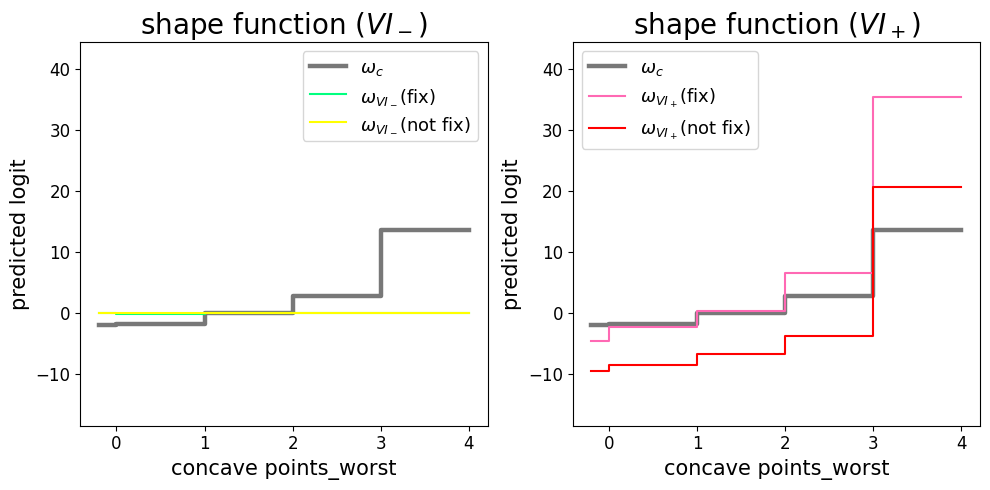

perimeter_worst
----------------------variable importance Minus----------------------
Second solve time: 0.001640762
log obj: 0.20159312740644703 rset_bound: 3.77682499986352
Second solve time: 0.001535832
log obj: 0.16422495714196456 rset_bound: 3.77682499986352
----------------------variable importance plus LP--------------------
time: 1.6467278003692627
log obj: 0.28527114301463335 rset_bound: 3.77682499986352
time: 0.8956921100616455
log obj: 0.29582617684026535 rset_bound: 3.77682499986352


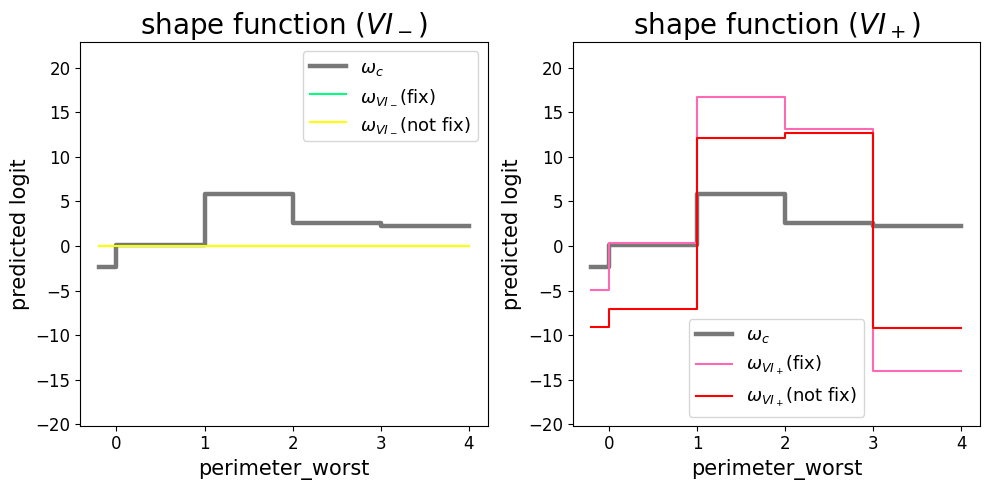

area_worst
----------------------variable importance Minus----------------------
Second solve time: 0.00161109
log obj: 0.20438800258179843 rset_bound: 3.77682499986352
Second solve time: 0.001568133
log obj: 0.1665191374828786 rset_bound: 3.77682499986352
----------------------variable importance plus LP--------------------
time: 1.4140653610229492
log obj: 0.32669199418334055 rset_bound: 3.77682499986352
time: 1.1599204540252686
log obj: 0.3049878523897319 rset_bound: 3.77682499986352


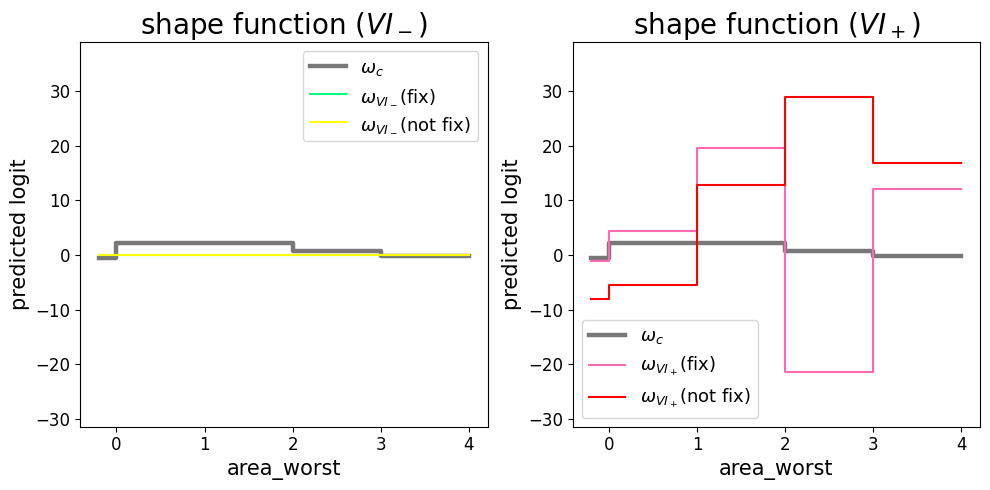

concave points_mean
----------------------variable importance Minus----------------------
Second solve time: 0.002619015
log obj: 0.20943184385475336 rset_bound: 3.77682499986352
Second solve time: 0.002562102
log obj: 0.18205312310245478 rset_bound: 3.77682499986352
----------------------variable importance plus LP--------------------
time: 1.9691407680511475
log obj: 0.24820368400173032 rset_bound: 3.77682499986352
time: 0.8839657306671143
log obj: 0.3232287140283727 rset_bound: 3.77682499986352


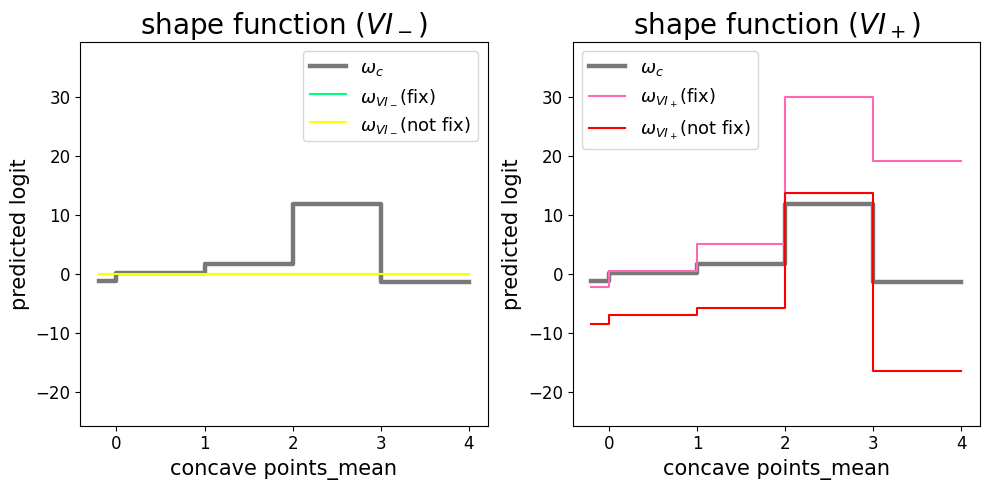

radius_worst
----------------------variable importance Minus----------------------
Second solve time: 0.001674996
log obj: 0.19612427115699166 rset_bound: 3.77682499986352
Second solve time: 0.001496451
log obj: 0.1645119114761309 rset_bound: 3.77682499986352
----------------------variable importance plus LP--------------------
time: 1.6125223636627197
log obj: 0.4020555901918598 rset_bound: 3.77682499986352
time: 0.8813321590423584
log obj: 0.5185957580493487 rset_bound: 3.77682499986352


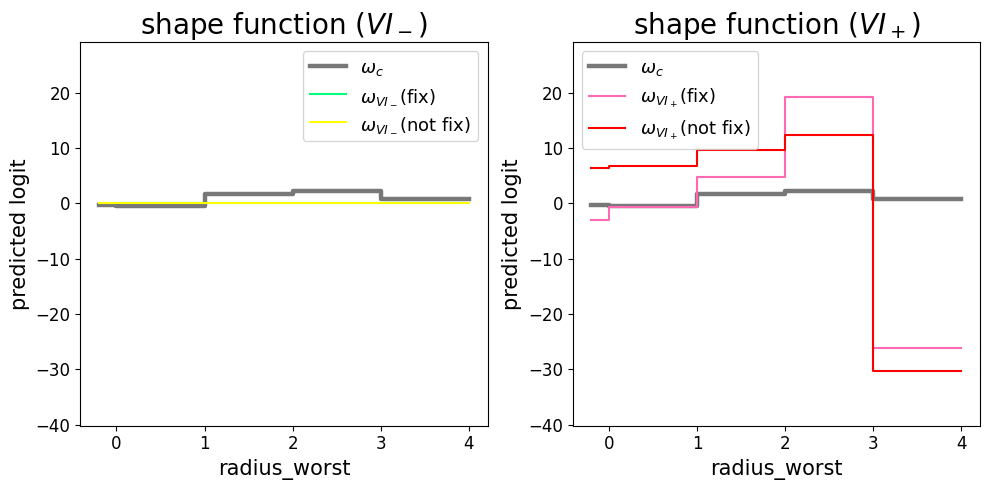

perimeter_mean
----------------------variable importance Minus----------------------
Second solve time: 0.002039144
log obj: 0.21556973302367172 rset_bound: 3.77682499986352
Second solve time: 0.001555628
log obj: 0.1573081256656885 rset_bound: 3.77682499986352
----------------------variable importance plus LP--------------------


/tmp/ipython-input-830/4235975229.py:47: UserWarning: solution is None for pattern 0
  warnings.warn(f"solution is None for pattern {j}")
/tmp/ipython-input-830/4235975229.py:47: UserWarning: solution is None for pattern 1
  warnings.warn(f"solution is None for pattern {j}")
/tmp/ipython-input-830/4235975229.py:47: UserWarning: solution is None for pattern 4
  warnings.warn(f"solution is None for pattern {j}")
/tmp/ipython-input-830/4235975229.py:47: UserWarning: solution is None for pattern 5
  warnings.warn(f"solution is None for pattern {j}")
/tmp/ipython-input-830/4235975229.py:47: UserWarning: solution is None for pattern 6
  warnings.warn(f"solution is None for pattern {j}")
/tmp/ipython-input-830/4235975229.py:47: UserWarning: solution is None for pattern 8
  warnings.warn(f"solution is None for pattern {j}")
/tmp/ipython-input-830/4235975229.py:47: UserWarning: solution is None for pattern 9
  warnings.warn(f"solution is None for pattern {j}")
/tmp/ipython-input-830/4235975229.

time: 2.029627561569214
log obj: 0.3100277447160824 rset_bound: 3.77682499986352
time: 0.8966014385223389
log obj: 0.32677738027860703 rset_bound: 3.77682499986352


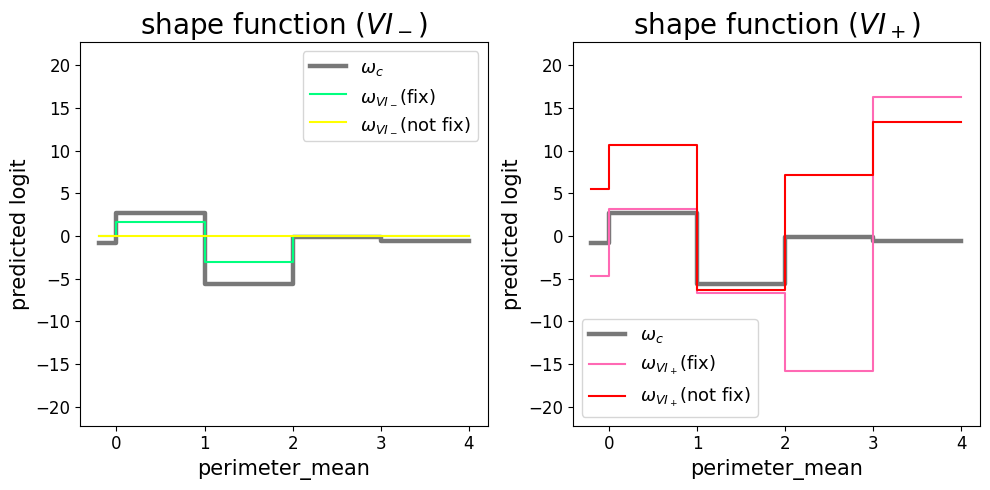

radius_mean
----------------------variable importance Minus----------------------
Second solve time: 0.00199843
log obj: 0.22367267312781264 rset_bound: 3.77682499986352
Second solve time: 0.001580335
log obj: 0.15866485719216578 rset_bound: 3.77682499986352
----------------------variable importance plus LP--------------------


/tmp/ipython-input-830/4235975229.py:47: UserWarning: solution is None for pattern 2
  warnings.warn(f"solution is None for pattern {j}")
/tmp/ipython-input-830/4235975229.py:47: UserWarning: solution is None for pattern 10
  warnings.warn(f"solution is None for pattern {j}")
/tmp/ipython-input-830/4235975229.py:47: UserWarning: solution is None for pattern 11
  warnings.warn(f"solution is None for pattern {j}")
/tmp/ipython-input-830/4235975229.py:47: UserWarning: solution is None for pattern 18
  warnings.warn(f"solution is None for pattern {j}")
/tmp/ipython-input-830/4235975229.py:47: UserWarning: solution is None for pattern 19
  warnings.warn(f"solution is None for pattern {j}")
/tmp/ipython-input-830/4235975229.py:47: UserWarning: solution is None for pattern 26
  warnings.warn(f"solution is None for pattern {j}")
/tmp/ipython-input-830/4235975229.py:47: UserWarning: solution is None for pattern 27
  warnings.warn(f"solution is None for pattern {j}")


time: 2.4378364086151123
log obj: 0.2819872133714185 rset_bound: 3.77682499986352
time: 1.3602962493896484
log obj: 0.3633536863355858 rset_bound: 3.77682499986352


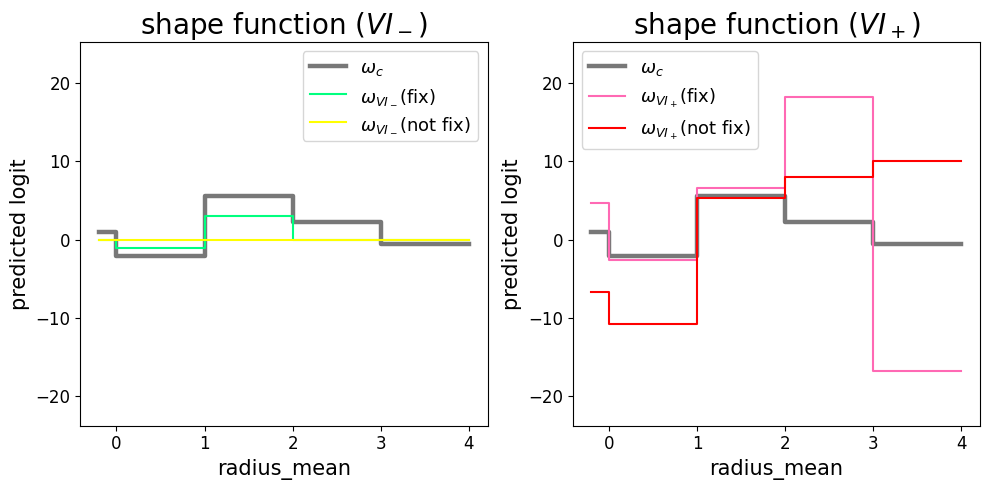

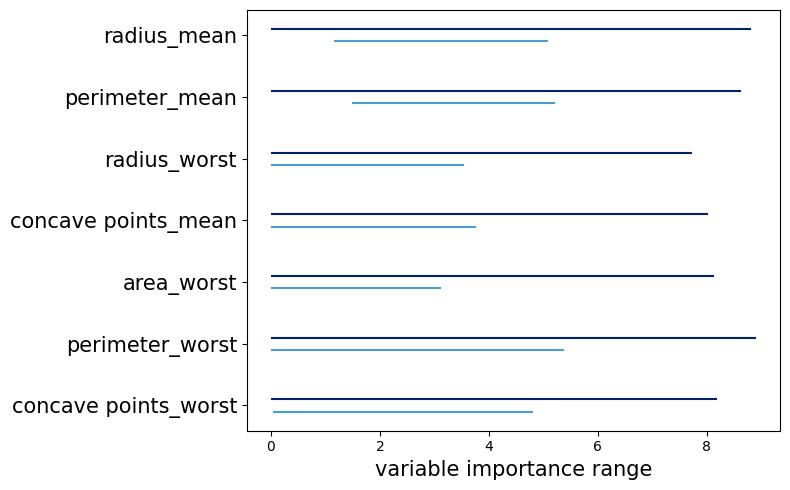

In [14]:
variable_importance_range(FILEPATH, mip=False, plot_shape=True, plot_vir=True)

## Application 3: Monotonicity

Features: ['concave points_worst', 'perimeter_worst', 'area_worst', 'concave points_mean', 'radius_worst', 'perimeter_mean', 'radius_mean']
feature radius_worst
----------------------monotonicity----------------------
Second solve time: 0.000864007
log obj: 0.18993570507861934 rset_bound: 3.77682499986352
updated w [ 1.75292413e-01 -1.98265413e+00 -1.68758360e+00  6.96659674e-03
  2.84792047e+00  1.36172985e+01 -2.34132127e+00  8.28067882e-02
  5.81513939e+00  2.39337153e+00  2.15161491e+00 -5.04161171e-01
  2.11256507e+00  1.99544925e+00  5.80211668e-01 -9.79907859e-01
 -1.18775335e+00  1.30917306e-01  1.61798353e+00  1.17423753e+01
 -1.75309069e+00 -3.72204892e-01 -3.72204892e-01  1.77636620e+00
  1.90091008e+00  1.90091008e+00 -7.98205031e-01  2.71455726e+00
 -5.60440206e+00 -1.12305559e-01 -2.58738647e-01  9.42142382e-01
 -2.12748987e+00  5.54279993e+00  2.31481600e+00 -8.38122438e-01]


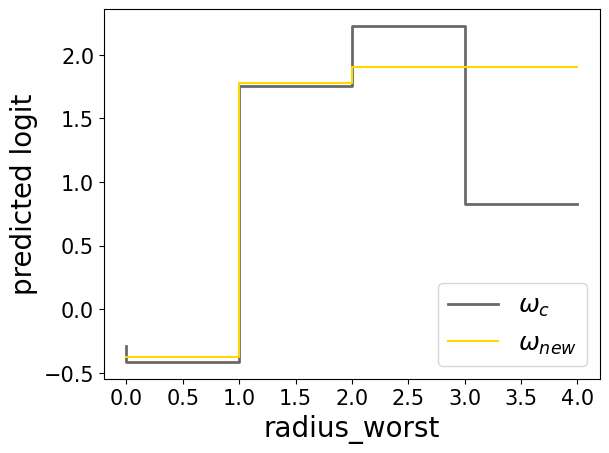

feature perimeter_worst
----------------------monotonicity----------------------
Second solve time: 0.000482657
log obj: 0.19187021816190775 rset_bound: 3.77682499986352
updated w [-0.05820721 -1.7875931  -1.55812632  0.14395009  3.13279703 13.9315092
 -2.31507565  0.12105585  5.25826775  5.25826775  5.25826775 -0.58249274
  2.15502711  2.68264085  0.41996755  0.52032446 -1.09711959  0.22399024
  1.75612646 11.97131943  0.61178222 -0.35176475 -0.41812616  1.72460084
  2.85117349 -1.72208162 -0.86967102  2.84117778 -5.61190602 -0.49305689
 -2.32515908  1.12882961 -2.1553063   5.62543278  1.6011353  -0.80885849]


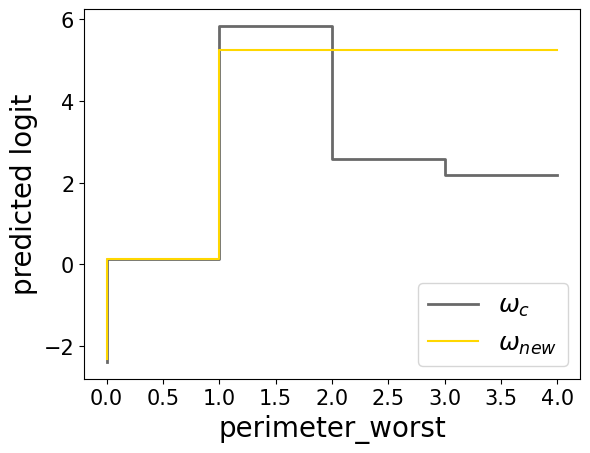

feature area_worst
----------------------monotonicity----------------------
Second solve time: 0.00059871
log obj: 0.19024759106811032 rset_bound: 3.77682499986352
updated w [ 0.38987788 -1.94660645 -1.68736841  0.02168415  2.91742618 13.77941259
 -2.42576196  0.11519754  5.87884548  2.73215912  1.65418654 -0.55968499
  2.05996973  2.05996973  2.05996973  2.05996973 -1.23858832  0.0970689
  1.59846272 11.54557357 -1.46733972 -0.33247028 -0.44658984  1.73618824
  2.35613781  0.31981762 -0.85900868  2.64328024 -5.64534399 -0.2319304
 -0.62422733  0.9203742  -2.15023444  5.48048139  2.0995211  -0.82126188]


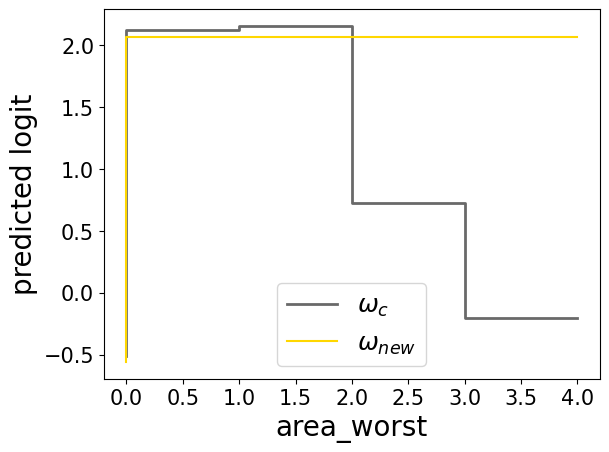

In [15]:
rset = RSetGAMs(FILEPATH)
print("Features:", [k for k in rset.xlabel.keys() if k != 'bias'])

get_monotone(FILEPATH, f="radius_worst",    direction="increase")
get_monotone(FILEPATH, f="perimeter_worst", direction="increase")
get_monotone(FILEPATH, f="area_worst",      direction="increase")

## Application 4: User-preferred shape

Bins for 'concave points_worst': [0, 0.0, 1.0, 2.0, 3.0, 4.0]
Current weights: [-1.95242112 -1.67806935  0.02580139  2.90882825 13.70294141]
feature concave points_worst
----------------------projection----------------------
Second solve time: 0.002843862
Second solve time: 0.002901245
log obj: 0.24332516345420704 rset_bound: 3.77682499986352
w_fix [ 1.72282253e-01 -5.00000000e-01 -2.50000000e-01 -1.43552093e-11
  2.50000000e-01  5.00000000e-01 -2.38913819e+00  1.25035196e-01
  5.84131419e+00  2.58160868e+00  2.18348468e+00 -5.14581405e-01
  2.12077955e+00  2.15294200e+00  7.22577849e-01 -2.07936662e-01
 -1.19123600e+00  1.29548137e-01  1.63987231e+00  1.17667866e+01
 -1.42866568e+00 -2.87671552e-01 -4.14639991e-01  1.75819709e+00
  2.22775923e+00  8.23692692e-01 -8.23786472e-01  2.71716119e+00
 -5.59630230e+00 -1.37852930e-01 -5.55579491e-01  9.29885190e-01
 -2.13249670e+00  5.52593892e+00  2.22605264e+00 -5.55579014e-01]
w_not_fix [ 1.72282253e-01 -5.00000000e-01 -2.50000001e-01 -9.4

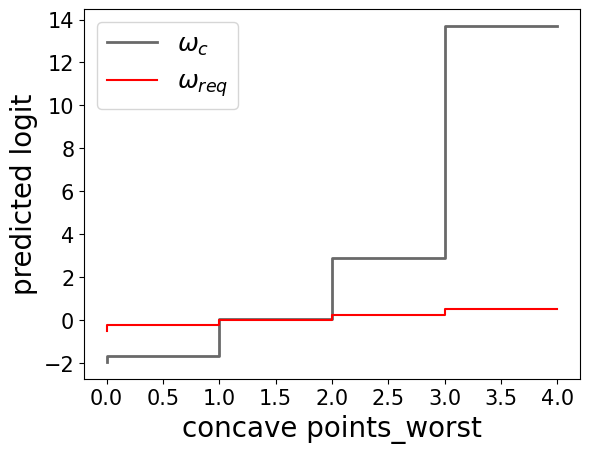

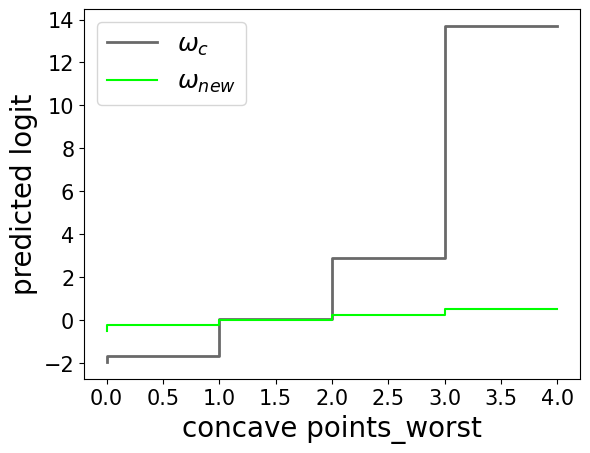

In [16]:
rset   = RSetGAMs(FILEPATH)
f_name = "concave points_worst"
l, cnt = rset.get_f_idx(f_name)
print(f"Bins for '{f_name}':", rset.xlabel[f_name])
print(f"Current weights: {rset.w_orig[l:l+cnt]}")

w_user = np.linspace(-0.5, 0.5, cnt)   # linear ramp preference
get_projection(FILEPATH, f=f_name, w_user=w_user)

## Application 5: Detect abnormal jumps

In [17]:
from src.run_app import test_jump

rset = RSetGAMs(FILEPATH)
for f_name in ["radius_worst", "concave points_worst"]:
    l, cnt = rset.get_f_idx(f_name)
    print(f"\n'{f_name}': index l={l}, cnt={cnt} bins")
    if cnt >= 3:
        cnt_jump = test_jump(FILEPATH, n_samples=500, i=l, j=l+1, k=l+2)
        print(f"  Non-monotone jump proportion: {cnt_jump/500:.3f}")


'radius_worst': index l=21, cnt=5 bins
proportion: 0.538
  Non-monotone jump proportion: 0.538

'concave points_worst': index l=1, cnt=5 bins
proportion: 0.394
  Non-monotone jump proportion: 0.394
